In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [118]:
orginal_data = pd.read_excel('Supply Chain & Sales Datasets.xlsx', engine='openpyxl')

orginal_data.head(5)


,Retail Order ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,Country,...,Category,Returned,Sales,Quantity,Discount,Profit,Cost,Unit CP,Unit SP,Days
0,1,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,42420,United States,...,Furniture,Not,261.9600,2,0.00,41.9136,220.0464,110.0232,130.9800,92
1,2,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,42420,United States,...,Furniture,Not,731.9400,3,0.00,219.5820,512.3580,170.7860,243.9800,92
2,3,CA-2016-138688,2016-12-06,2016-12-06,Second Class,DV-13045,Darrin Van Huff,Corporate,90036,United States,...,Office Supplies,Not,14.6200,2,0.00,6.8714,7.7486,3.8743,7.3100,0
3,4,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,33311,United States,...,Furniture,Not,957.5775,5,0.45,-383.0310,1340.6085,268.1217,191.5155,0
4,5,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,33311,United States,...,Office Supplies,Not,22.3680,2,0.20,2.5164,19.8516,9.9258,11.1840,0


In [120]:
orginal_data.isnull().values.any()

np.False_

In [172]:
# Filter orders only from 2014
data = orginal_data[orginal_data['Order Date'].dt.year == 2017]

# Make sure 'Order Date' is in datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_4568\460385979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Order Date'] = pd.to_datetime(data['Order Date'])


# Customer Retention Analysis

In [151]:
# Drop duplicate orders (in case multiple rows exist per product in an order)
retention_data = data[['Customer ID', 'Order ID', 'Order Date']].drop_duplicates()

# Sort by Customer and Order Date
retention_data = retention_data.sort_values(by=['Customer ID', 'Order Date'])

print(retention_data)

     Customer ID        Order ID Order Date
1159    AA-10315  CA-2017-147039 2017-06-29
9538    AA-10375  US-2017-169488 2017-07-09
6747    AA-10375  CA-2017-100230 2017-11-12
12      AA-10480  CA-2017-114412 2017-04-15
7489    AA-10645  CA-2017-157196 2017-05-11
...          ...             ...        ...
1228    ZC-21910  CA-2017-100013 2017-06-11
4100    ZC-21910  US-2017-102288 2017-06-19
7315    ZC-21910  CA-2017-115322 2017-11-05
8923    ZC-21910  CA-2017-133928 2017-11-06
8341    ZD-21925  CA-2017-141481 2017-11-06

[1687 rows x 3 columns]


## Time Between Orders

In [ ]:
# Calculate time difference between current and previous order per customer
customer_orders = retention_data.copy()
customer_orders['Days Between Orders'] = customer_orders.groupby('Customer ID')['Order Date'].diff().dt.days

print(customer_orders)

     Customer ID        Order ID Order Date  Days Between Orders
2229    AA-10315  CA-2014-128055 2014-03-31                  NaN
7468    AA-10315  CA-2014-138100 2014-09-15                168.0
1172    AA-10375  CA-2014-158064 2014-04-21                  NaN
3007    AA-10375  CA-2014-130729 2014-10-24                186.0
1459    AA-10480  CA-2014-155271 2014-04-05                  NaN


In [132]:
average_time = customer_orders.groupby('Customer ID')['Days Between Orders'].mean().reset_index()
average_time.columns = ['Customer ID', 'Avg Days Between Orders']
print(average_time)

    Customer ID  Avg Days Between Orders
0      AA-10315                    168.0
1      AA-10375                    186.0
2      AA-10480                      NaN
3      AA-10645                    161.0
4      AB-10015                    135.0
..          ...                      ...
590    WB-21850                    126.5
591    XP-21865                    125.5
592    YC-21895                      NaN
593    ZC-21910                     77.0
594    ZD-21925                      NaN

[595 rows x 2 columns]


In [133]:
def categorize_frequency(avg_days):
    if pd.isna(avg_days):
        return 'New Customer'  # If no previous orders, categorize as 'New'
    elif avg_days <= 7:
        return 'Frequent - Every Week'  # Orders are placed weekly or more frequently
    elif avg_days <= 30:
        return 'Occasional - Monthly'  # Orders are placed around once a month
    elif avg_days <= 90:
        return 'Rare - Quarterly'  # Orders are placed quarterly or every few months
    else:
        return 'Dormant - Inactive'  # No orders for 3 months or more

In [134]:
# Apply categorization function
average_time['Order Frequency Category'] = average_time['Avg Days Between Orders'].apply(categorize_frequency)

# Display the result
print(average_time[['Customer ID', 'Avg Days Between Orders', 'Order Frequency Category']].head())

  Customer ID  Avg Days Between Orders Order Frequency Category
0    AA-10315                    168.0       Dormant - Inactive
1    AA-10375                    186.0       Dormant - Inactive
2    AA-10480                      NaN             New Customer
3    AA-10645                    161.0       Dormant - Inactive
4    AB-10015                    135.0       Dormant - Inactive


In [137]:
# Calculate count and percentage of each category
frequency_count = average_time['Order Frequency Category'].value_counts()

# Calculate the percentage
frequency_percentage = (frequency_count / frequency_count.sum()) * 100

# Combine the count and percentage into a DataFrame
frequency_summary = pd.DataFrame({
    'Count': frequency_count,
    'Percentage': frequency_percentage
})

# Display the result
print(frequency_summary)

                          Count  Percentage
Order Frequency Category                   
New Customer                332   55.798319
Dormant - Inactive          145   24.369748
Rare - Quarterly             82   13.781513
Occasional - Monthly         28    4.705882
Frequent - Every Week         8    1.344538


In [136]:
# Calculate the overall optimal time between orders (e.g., using the median of all customers)
overall_optimal_time = customer_orders['Days Between Orders'].median()

print(f"Overall Optimal Time Between Orders: {overall_optimal_time} days")

Overall Optimal Time Between Orders: 94.0 days


In [138]:
# Calculate the overall optimal time between orders (e.g., using the median of all customers)
overall_avg_time = customer_orders['Days Between Orders'].mean()

print(f"Average Time Between Orders: {overall_avg_time} days")

Average Time Between Orders: 105.0909090909091 days


## Purchase Frequency

In [158]:
customer_order_count = retention_data.copy()

# Step 1: Count the number of orders for each customer
customer_order_counts = retention_data.groupby('Customer ID')['Order ID'].nunique()
customer_order_counts

Customer ID
AA-10315    1
AA-10375    2
AA-10480    1
AA-10645    1
AB-10060    4
           ..
XP-21865    4
YC-21895    1
YS-21880    5
ZC-21910    4
ZD-21925    1
Name: Order ID, Length: 693, dtype: int64

In [159]:
# Step 2: Calculate the total number of orders made by all customers
total_orders = customer_order_counts.sum()
total_orders

np.int64(1687)

In [164]:
# Step 3: Calculate the total number of distinct customers
total_customers = customer_order_counts.count()
total_customers

np.int64(693)

In [165]:
# Step 4: Calculate Purchase Frequency (average orders per customer)
purchase_frequency = total_orders / total_customers

print(f"Purchase Frequency: {purchase_frequency:.2f}")

Purchase Frequency: 2.43


## Average Order Value

# Top 5 days with the highest number of orders

In [173]:
# Drop duplicate orders (in case there are multiple products per order)
unique_orders = data[['Order ID', 'Order Date']].drop_duplicates()

# Count number of orders per day
orders_per_day = unique_orders.groupby('Order Date').size().reset_index(name='Order Count')

# Sort and get top 5 days with most orders
top_5_days = orders_per_day.sort_values(by='Order Count', ascending=False).head(10)

# Now sort the top 5 by date in ascending order
top_5_days = top_5_days.sort_values(by='Order Date', ascending=True)

print(top_5_days)

    Order Date  Order Count
9   2017-01-12           14
32  2017-02-09           14
35  2017-02-12           16
58  2017-03-11           16
83  2017-04-09           16
161 2017-07-09           15
221 2017-09-12           15
276 2017-11-13           14
282 2017-11-19           15
287 2017-11-24           15


In [ ]:
customer_order_count = retention_data.copy()

In [ ]:
customer_order_count

In [68]:
total_orders = data['Order ID'].nunique()
returned_data = data[data['Returned'] == 'Yes']
returned_order = returned_data['Order ID'].nunique()
print(returned_order)
print(total_orders)


77
1315


In [54]:
print(returned_order/total_orders)

0.05908183632734531


In [21]:
selected_columns = ['Profit', 'Days', 'Sales', 'Discount', 'Cost', 'Quantity']
corr_data = data[selected_columns]
corr_data.head(5)

,Profit,Days,Sales,Discount,Cost,Quantity
0,41.9136,92,261.9600,0.00,220.0464,2
1,219.5820,92,731.9400,0.00,512.3580,3
2,6.8714,0,14.6200,0.00,7.7486,2
3,-383.0310,0,957.5775,0.45,1340.6085,5
4,2.5164,0,22.3680,0.20,19.8516,2


<Axes: >

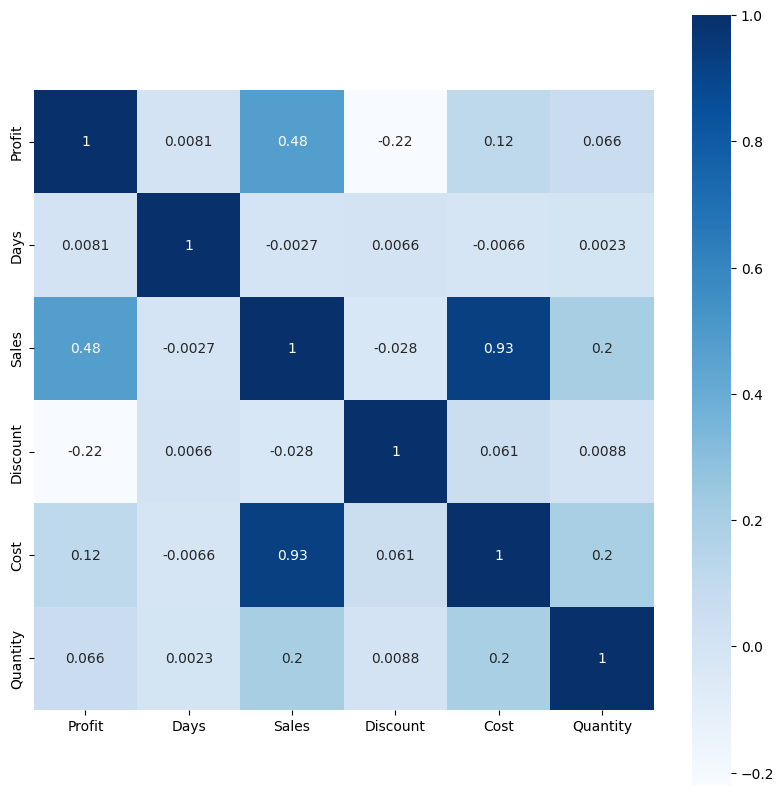

In [22]:
correlation = corr_data.corr()
fig = plt.subplots(figsize = (10,10))
sn.heatmap(correlation, vmax=1, square = True, annot = True, cmap = 'Blues')

In [20]:
# Check if each Product ID has a unique Unit CP
inconsistent_products = data.groupby("Product ID")["Unit CP"].nunique() > 1
print(inconsistent_products)

# Filter Product IDs where Unit CP is NOT consistent
inconsistent_products = inconsistent_products[inconsistent_products].index


Product ID
0                  False
FUR-BO-10000112    False
FUR-BO-10000330    False
FUR-BO-10000362    False
FUR-BO-10000468     True
                   ...  
TEC-PH-10004912    False
TEC-PH-10004922     True
TEC-PH-10004924     True
TEC-PH-10004959    False
TEC-PH-10004977    False
Name: Unit CP, Length: 1863, dtype: bool


In [ ]:
# Display results
if len(inconsistent_products) > 0:
    print("Products with inconsistent Unit CP:", inconsistent_products.tolist())
else:
    print("All Product IDs have the same Unit CP.")

In [25]:
# Ensure necessary columns exist
if not all(col in data.columns for col in ['Product ID', 'Quantity', 'Unit CP']):
    raise ValueError("Dataset must contain 'Product ID', 'Quantity', and 'Unit Price' columns.")

In [30]:
# Step 2: Aggregate revenue per product
df_abc = data.groupby("Sub-Category")["Sales"].sum().reset_index()

# Step 3: Sort by revenue in descending order
df_abc = df_abc.sort_values(by="Sales", ascending=False)

# Step 4: Compute cumulative percentage of total revenue
df_abc["Cumulative Revenue"] = df_abc["Sales"].cumsum()
df_abc["Cumulative Percentage"] = (df_abc["Cumulative Revenue"] / df_abc["Sales"].sum()) * 100

# Step 5: Assign ABC categories
def categorize_abc(percentage):
    if percentage <= 60:
        return "A"
    elif percentage <= 80:
        return "B"
    else:
        return "C"

df_abc["ABC Category"] = df_abc["Cumulative Percentage"].apply(categorize_abc)

# Step 6: Select only required columns
df_result = df_abc[["Sub-Category", "Cumulative Percentage", "ABC Category"]]


In [33]:
# Display results
print(df_result)

   Sub-Category  Cumulative Percentage ABC Category
14       Phones              14.365616            A
6        Chairs              28.663412            A
15      Storage              38.407602            A
17       Tables              47.417068            A
4       Binders              56.271876            A
12     Machines              64.509669            B
1   Accessories              71.795941            B
7       Copiers              78.305082            B
5     Bookcases              83.305950            C
2    Appliances              87.986958            C
10  Furnishings              91.978998            C
13        Paper              95.395295            C
16     Supplies              97.427052            C
3           Art              98.607567            C
8     Envelopes              99.324805            C
11       Labels              99.868349            C
9     Fasteners             100.000000            C
0             0             100.000000            C


In [42]:
# Step 1: Group by Sub-Category and calculate demand statistics
df_xyz = data.groupby("Sub-Category")["Quantity"].agg(['mean', 'std']).reset_index()

# Step 2: Compute Coefficient of Variation (CV)
df_xyz["CV"] = df_xyz["std"] / df_xyz["mean"]

# Step 3: Assign XYZ categories based on CV
def categorize_xyz(cv):
    if cv <= 0.1:
        return "X"  # Stable demand
    elif cv <= 0.3:
        return "Y"  # Moderate variability
    else:
        return "Z"  # High variability

df_xyz["XYZ Category"] = df_xyz["CV"].apply(categorize_xyz)

In [44]:

# Display final ABC-XYZ classification
print(df_xyz)

   Sub-Category      mean       std        CV XYZ Category
0             0  0.000000       NaN       NaN            Z
1   Accessories  3.840000  2.284698  0.594973            Z
2    Appliances  3.710300  2.123038  0.572201            Z
3           Art  3.768844  2.131957  0.565679            Z
4       Binders  3.922521  2.291913  0.584296            Z
5     Bookcases  3.807018  2.283352  0.599774            Z
6        Chairs  3.818476  2.282652  0.597791            Z
7       Copiers  3.441176  1.831583  0.532255            Z
8     Envelopes  3.566929  2.045299  0.573406            Z
9     Fasteners  4.211982  2.413551  0.573020            Z
10  Furnishings  3.723093  2.155954  0.579076            Z
11       Labels  3.846154  2.349248  0.610804            Z
12     Machines  3.826087  2.165361  0.565947            Z
13        Paper  3.779562  2.231560  0.590428            Z
14       Phones  3.699663  2.189453  0.591798            Z
15      Storage  3.732861  2.192409  0.587327           